In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime
import math
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
sc = StandardScaler()
scaler = MinMaxScaler()

In [3]:
# n: patient number formatted as 0xx
def read_data(n):
    df_bolus = pd.read_csv(f'data-orig/CAPE{n}-Bolusing-Derived.csv', parse_dates=['EventDateTime', 'RequestDateTime', 'CompletionDateTime'], infer_datetime_format=True)
    df_bolus = df_bolus.loc[df_bolus['FoodDelivered']!=0] 
    tmp = {'date':df_bolus['CompletionDateTime'], 'food':df_bolus['FoodDelivered']}
    df_bolus = pd.DataFrame(tmp)
    df_cgm = pd.read_csv(f'data-orig/CAPE{n}-CGM-derived.csv',parse_dates=['EventDateTime'], infer_datetime_format=True)
    df_cal = pd.read_csv(f'data-orig/CAPE-{n}_AppleHealthData.csv', parse_dates=['StartDate'],infer_datetime_format=True, low_memory = False)
    df_cal.dropna(subset=['Type', 'StartDate'])
    df_aeb = df_cal.loc[df_cal['Type']=="HKQuantityTypeIdentifierActiveEnergyBurned"]
    return df_bolus, df_cgm, df_aeb

In [4]:
df_bolus, df_cgm, df_aeb = read_data("014")


In [5]:
#function to create the dataset with 30 mins windows
#end: end date and time of the actual data we have that depends on the patient
#start: start date and time of the actual data we have that depends on the patient
#n: the number of hours that we want to get(for example if we want results from 10am to 1 pm n is 3.)
def create_windows(end, start, df_aeb, df_bolus, df_cgm, n):
    last_meal = df_bolus.iloc[0]
    foods = []
    bgms = []
    aebs = []
    deltas = []
    while start <= end:
        x1 = df_bolus.loc[df_bolus['date']<start+timedelta(days=1)]
        x1 = x1.loc[x1['date']>=start]

        x2 = df_cgm.loc[df_cgm['EventDateTime']<start+timedelta(days=1)]
        x2 = x2.loc[x2['EventDateTime']>=start]

        x3 = df_aeb.loc[df_aeb['StartDate']<start+timedelta(days=1)]
        x3 = x3.loc[x3['StartDate']>=start]    
        # print(x)
        # print("---")
        day_end = start+timedelta(hours=n)
        day = []
        while start != day_end:
            x_day1 = x1.loc[x1['date']<start+timedelta(minutes=30)]
            x_day1 = x_day1.loc[x_day1['date']>=start]
            total_meal = x_day1['food'].sum()
            if x_day1.empty==False:
                last_meal = x_day1.iloc[-1]

            x_bgm = x2.loc[x2['EventDateTime']<start+timedelta(minutes=30)]
            x_bgm = x_bgm.loc[x_bgm['EventDateTime']>=start]
            average_bgm = x_bgm["Readings (CGM / BGM)"].mean()
            if math.isnan(average_bgm)==True:
                average_bgm = 0

            x_aeb = x3.loc[x3['StartDate']<start+timedelta(minutes=30)]
            x_aeb = x_aeb.loc[x_aeb['StartDate']>=start]
            # print(x_aeb['Value'])
            total_burned = x_aeb['Value'].sum()
            # print(total_burned)
        

            if start<=last_meal['date']:
                delta = 0
            else:
                delta = start
                delta -= last_meal['date']
                delta = delta.seconds/3600

            foods.append(total_meal)
            bgms.append(average_bgm)
            aebs.append(total_burned)
            deltas.append(delta)
            start += timedelta(minutes=30)
        start += timedelta(hours=24-n)
    df_foods = pd.DataFrame(foods)
    df_bgms = pd.DataFrame(bgms)
    df_aebs = pd.DataFrame(aebs)
    df_deltas = pd.DataFrame(deltas)
    return (df_foods, df_bgms, df_aebs, df_deltas)


In [6]:
#it is important to specify the time of the start as 4 and n = 6 if we want the data from 4 to 10 or start time as 10 and n = 3

start = datetime(2022,2,7,10,0,0)
end = datetime(2022,2,24,0,0,0)
df_foods, df_bgms, df_aebs, df_deltas = create_windows(end, start, df_aeb, df_bolus, df_cgm, 3)


In [7]:
#individually scale everything
def transform(df_foods, df_bgms, df_aebs, df_deltas):
    df_foods = scaler.fit_transform(df_foods)
    df_bgms = scaler.fit_transform(df_bgms)
    df_aebs = scaler.fit_transform(df_aebs)
    df_deltas = scaler.fit_transform(df_deltas)
    return (df_foods, df_bgms, df_aebs, df_deltas)

df_foods, df_bgms, df_aebs, df_deltas = transform(df_foods, df_bgms, df_aebs, df_deltas)


In [119]:
#use this function if you are going to calculate the distance from every feature
def divide_days(n, df_foods, df_bgms, df_aebs, df_deltas, numberofdays):
    days = np.zeros((numberofdays,n*4))
    for i in range(numberofdays):
        tmp1 = df_deltas[i*n:(i+1)*n]
        tmp2 = df_bgms[i*n:(i+1)*n]
        tmp3 = df_aebs[i*n:(i+1)*n]
        tmp4 = df_foods[i*n:(i+1)*n]
        tmp5 = np.concatenate((tmp2,tmp1), axis=0)
        tmp6 = np.concatenate((tmp3, tmp4), axis=0)
        #print(tmp5)
        last = np.concatenate((tmp5, tmp6), axis=0)
        for j in range(len(last)):
            days[i,j] = last[j][0]

    return days

days = divide_days(12, df_foods, df_bgms, df_aebs, df_deltas,17)
print(days)

(17, 48)
[[2.86702916e-01 3.23282254e-01 6.23331686e-01 6.39644093e-01
  6.85615423e-01 6.51013347e-01 7.39495798e-01 9.21403856e-01
  9.82204647e-01 9.77261493e-01 1.00000000e+00 9.44142363e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 6.02988010e-03 0.00000000e+00
  6.05329712e-03 0.00000000e+00 1.33476958e-02 3.44230049e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 8.32637685e-03
  3.27382864e-01 4.15740919e-01 2.51161198e-01 2.60236735e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 7.93147208e-01 0.00000000e+00 4.75888325e-01
  0.00000000e+00 4.75888325e-01 0.00000000e+00 0.00000000e+00]
 [6.23826001e-01 5.67474048e-01 5.05190311e-01 4.65645082e-01
  4.34503213e-01 4.35491844e-01 4.92338112e-01 6.50519031e-01
  6.57933762e-01 6.13445378e-01 5.69451310e-01 5.52644587e-01
  8.14209442e-01 8.35284751e-01 8.56360060e-01 8.77435369e-0

In [9]:
#use this function if you want to calculate the distance for only blood glucose levels
def bgl(n, df_foods, df_bgms, df_aebs, df_deltas,numberofdays):
    days = np.zeros((numberofdays,n))

    for i in range(numberofdays):
        tmp2 = df_bgms[i*n:(i+1)*n]
        for j in range(len(tmp2)):
            days[i][j] = tmp2[j]
    return days

In [25]:
days=bgl(6,df_foods, df_bgms, df_aebs, df_deltas,18)

In [26]:
from numpy.linalg import norm

#calculate the distances
def resulting_distances(days):
    n = days.shape[0]
    distance = np.zeros((n,n))
    cosine = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
        # distance: Euclidean Distance
            distance[i][j] = (np.sqrt(np.sum([x**2 for x in np.subtract(days[i], days[j])])))
            cosine[i,j] = np.dot(days[i],days[j])/(norm(days[i])*norm(days[j]))
    return distance, cosine


In [27]:
euclidean, cosine = resulting_distances(days)

euclidean = pd.DataFrame(euclidean)
cosine = pd.DataFrame(cosine)

euclidean

C:\Users\zehra\AppData\Local\Temp\ipykernel_17680\2868337419.py:12: RuntimeWarning: invalid value encountered in double_scalars
  cosine[i,j] = np.dot(days[i],days[j])/(norm(days[i])*norm(days[j]))


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.000000,0.557343,0.318142,0.313431,0.474810,0.842130,0.610892,0.377378,0.540352,0.563251,0.847912,0.643744,0.563336,1.255712,0.871404,0.844128,0.990887,1.552224
1,0.557343,0.000000,0.295100,0.282998,0.208922,0.925988,0.939036,0.315195,0.531336,0.891289,0.684928,0.123374,0.240731,0.867645,0.669588,1.103066,1.312428,1.014929
2,0.318142,0.295100,0.000000,0.097051,0.168459,0.745032,0.690569,0.124866,0.344243,0.642899,0.797171,0.393431,0.346129,1.000009,0.621293,0.853090,1.065607,1.298832
3,0.313431,0.282998,0.097051,0.000000,0.190561,0.765736,0.705141,0.128482,0.384882,0.650797,0.778453,0.378715,0.356138,1.006746,0.645908,0.880174,1.081151,1.292907
4,0.474810,0.208922,0.168459,0.190561,0.000000,0.754959,0.764026,0.167921,0.338089,0.726382,0.774972,0.282852,0.318279,0.866819,0.525574,0.904116,1.136658,1.173461
5,0.842130,0.925988,0.745032,0.765736,0.754959,0.000000,0.510150,0.651432,0.441271,0.453681,1.452892,0.979167,1.004279,1.331317,0.477226,0.410372,0.556995,1.792692
6,0.610892,0.939036,0.690569,0.705141,0.764026,0.510150,0.000000,0.649735,0.539041,0.144681,1.268874,0.991650,0.993259,1.426335,0.777718,0.358309,0.449953,1.908291
7,0.377378,0.315195,0.124866,0.128482,0.167921,0.651432,0.649735,0.000000,0.272376,0.590636,0.865227,0.401524,0.404601,1.002829,0.531589,0.801891,1.005675,1.312509
8,0.540352,0.531336,0.344243,0.384882,0.338089,0.441271,0.539041,0.272376,0.000000,0.498695,1.046212,0.595399,0.586642,1.037610,0.350292,0.597839,0.844910,1.448420
9,0.563251,0.891289,0.642899,0.650797,0.726382,0.453681,0.144681,0.590636,0.498695,0.000000,1.266520,0.952294,0.945930,1.438037,0.749069,0.390023,0.448026,1.874609


In [23]:
n = "014" # patient number
s = "10am-1pm"

#save the result
euclidean.to_csv(f'CAPE Distances/CAPE-{n}({s}).csv')

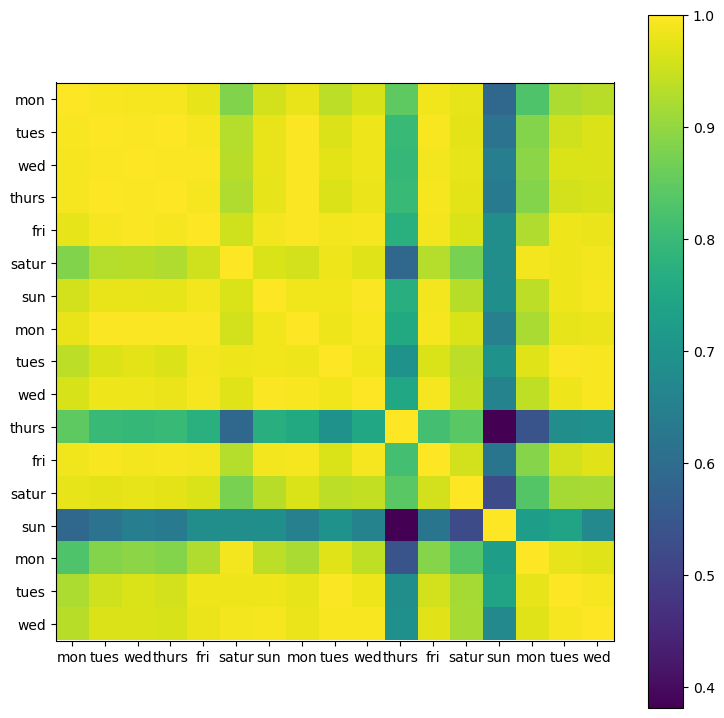

In [18]:
row = ["mon","tues","wed","thurs","fri","satur","sun","mon","tues","wed","thurs","fri","satur","sun","mon","tues","wed"]
fig, ax = plt.subplots(figsize=(9,9))
  
im = ax.imshow(cosine)
ax.set_xticks(np.arange(cosine.shape[1]), labels=row)
ax.set_yticks(np.arange(cosine.shape[0]), labels=row)
  
plt.colorbar(im, ax=ax)
plt.show()



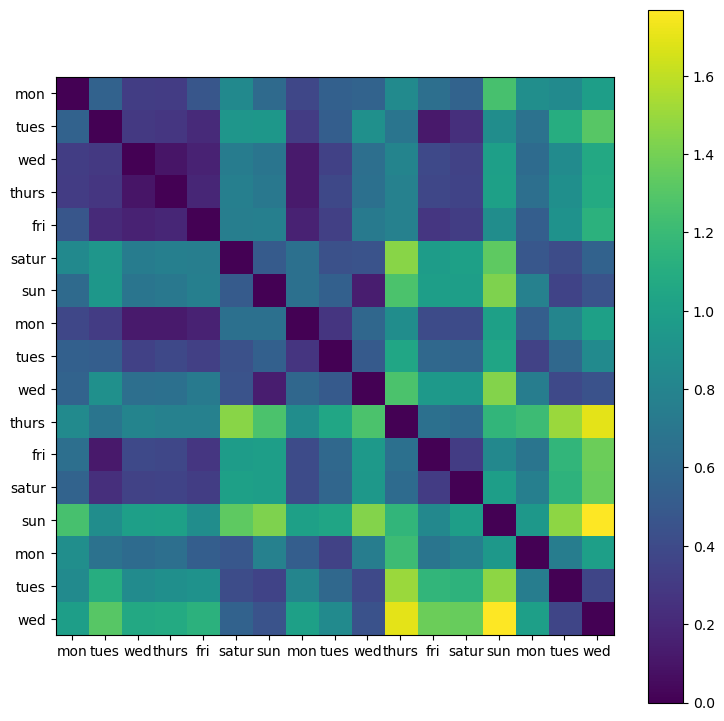

In [19]:
fig, ax = plt.subplots(figsize=(9,9))
  
im = ax.imshow(euclidean)
ax.set_xticks(np.arange(euclidean.shape[1]), labels=row)
ax.set_yticks(np.arange(euclidean.shape[0]), labels=row)
  
plt.colorbar(im, ax=ax)
plt.show()